In [36]:
!pip install kaggle

In [37]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [38]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [39]:
!kaggle datasets download -d madisona/translated-animals10

translated-animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
!unzip -q translated-animals10.zip

replace animals10/raw-img/butterfly/OIP--04ndbWy7I04gsPgu9qOeQHaHs.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [44]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
local_zip = 'translated-animals10.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
train_dir = os.path.join('/tmp/animals10/raw-img')
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.1) # set validation split

In [45]:
os.listdir('/tmp/animals10/raw-img')

['horse',
 'dog',
 'sheep',
 'chicken',
 'butterfly',
 'elephant',
 'squirrel',
 'cat',
 'spider',
 'cow']

In [46]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 23565 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.layers[0].trainable = False

In [49]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [50]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [51]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              verbose=2, callbacks=[callbacks])

Epoch 1/50
2946/2946 - 238s - loss: 1.0300 - accuracy: 0.8136 - val_loss: 0.4634 - val_accuracy: 0.8627 - 238s/epoch - 81ms/step
Epoch 2/50
2946/2946 - 249s - loss: 0.4068 - accuracy: 0.8809 - val_loss: 0.3933 - val_accuracy: 0.8814 - 249s/epoch - 85ms/step
Epoch 3/50
2946/2946 - 228s - loss: 0.3510 - accuracy: 0.8964 - val_loss: 0.3367 - val_accuracy: 0.8952 - 228s/epoch - 77ms/step
Epoch 4/50
2946/2946 - 228s - loss: 0.3121 - accuracy: 0.9095 - val_loss: 0.4037 - val_accuracy: 0.9002 - 228s/epoch - 77ms/step
Epoch 5/50
2946/2946 - 228s - loss: 0.2851 - accuracy: 0.9175 - val_loss: 0.3800 - val_accuracy: 0.8925 - 228s/epoch - 77ms/step
Epoch 6/50

Akurasi telah mencapai >92%!
2946/2946 - 230s - loss: 0.2617 - accuracy: 0.9256 - val_loss: 0.3885 - val_accuracy: 0.9051 - 230s/epoch - 78ms/step


In [52]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'tmp/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi pets.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('pets.tflite')
tflite_model_file.write_bytes(tflite_model)

338208616

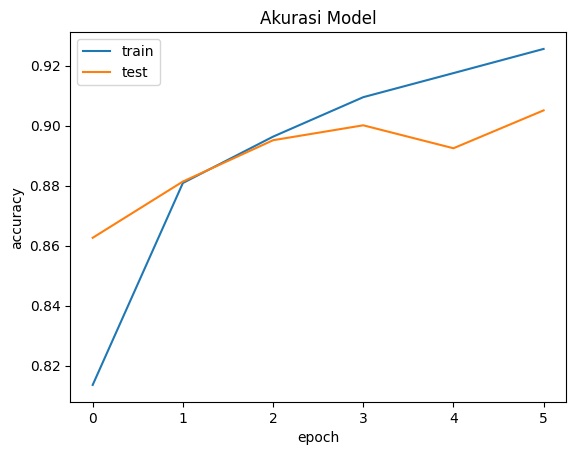

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

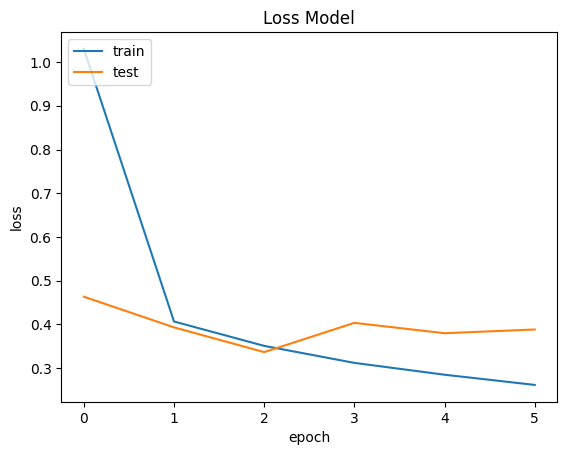

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()